### Classification on CIFAR Dataset

#### Loading the Libraries

In [57]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image
%matplotlib inline

#### Downloading the dataset if not present using Torchvision Dataset Library

* Using Torchvision's Transform function, we transform images to tensor and normalize it with mean and std over each channel of the Image.

In [7]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='/home/mayur/Desktop/Pytorch/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [8]:
testset = torchvision.datasets.CIFAR10(root='/home/mayur/Desktop/Pytorch/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


Checking hierarchy of the class of CIFAR dataset

In [9]:
type(trainset).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 object)

#### Loading one Image and checking its label !

In [10]:
img, label = trainset[0]

In [58]:
save_image(img, '/home/mayur/Desktop/Model_Deployment/sample_image.jpg')

In [61]:
PIL_image = Image.open('/home/mayur/Desktop/Model_Deployment/sample_image.jpg')
torch_img = transforms.ToTensor()(PIL_image)

In [62]:
torch_img.shape

torch.Size([3, 32, 32])

### How to Normalize Image

Above in transforms section, I have used 0.5 as mean and std across 3 channels. The way to find the mean and std of an image with three channel.

Why Normalize images for whole dataset ?

https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current

In [11]:
imgs = torch.stack([img_t for img_t, _ in trainset], dim=3)

In [12]:
imgs.shape

torch.Size([3, 32, 32, 50000])

In [13]:
imgs.view(3, -1).mean(dim=1) # Recall that view(3, -1) keeps the three channels and merges all the remaining dimensions into one, figuring out the appropriate size

tensor([-0.0172, -0.0357, -0.1070])

In [14]:
imgs.view(3, -1).std(dim=1)

tensor([0.4941, 0.4870, 0.5232])

**We can replace mean and std with newly found values in transforms.Normalize()**

### Creating Classification Model

**Create a Subset of full dataset by keeping only keeping two sets of images like birds and airplane.**

In [15]:
#Label Mapping - classification of two class 

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar_2 = [(img, label_map[label1]) for img, label1 in trainset if label1 in [0,2]]

In [16]:
cifar2_val = [(img, label_map[label])
for img, label in testset
if label in [0, 2]]

**How to flatten a matrix**

In [17]:
two_dimension = torch.randn(4,5)

In [18]:
two_dimension.view(-1)

tensor([ 0.2354, -0.1260, -1.4139,  0.0181, -0.7167, -1.8803, -0.3555, -0.8785,
        -0.5474,  0.3860, -2.0155,  0.5652,  0.9730,  0.1102,  1.4525, -0.5118,
         1.2378, -0.9805,  0.3566, -0.8049])

In [19]:
two_dimension

tensor([[ 0.2354, -0.1260, -1.4139,  0.0181, -0.7167],
        [-1.8803, -0.3555, -0.8785, -0.5474,  0.3860],
        [-2.0155,  0.5652,  0.9730,  0.1102,  1.4525],
        [-0.5118,  1.2378, -0.9805,  0.3566, -0.8049]])

**32 × 32 × 3: that is, 3,072 input features per sample**

In [20]:
i_feat = cifar_2[0][0].view(-1).shape[0]

In [21]:
n_out = 2

In [22]:
clf_model = nn.Sequential(
    nn.Linear(i_feat, 512),
    nn.Tanh(),
    nn.Linear(512, n_out)
)

**Representing the output using Probabilities, since the output is categorical. We can use softmax to bring down each class predicated value in range of 0 to 1.**

In [23]:
def softmax(x):
    return torch.exp(x)/ torch.exp(x).sum()

In [24]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [25]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],
[1.0, 2.0, 3.0]])

In [26]:
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [27]:
clf_model_smax = nn.Sequential(
    clf_model,
    nn.Softmax(dim=1)
)

In [28]:
clf_model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
)

In [29]:
img, _ = cifar_2[0]

In [30]:
img_batch = img.view(-1).unsqueeze(0)
out = clf_model(img_batch)
out

tensor([[-0.1327, -0.1389]], grad_fn=<AddmmBackward>)

In [31]:
_, index = torch.max(out, dim=1)
index

tensor([0])

In [32]:
clf_model_logSmax = nn.Sequential(
    clf_model,
    nn.LogSoftmax(dim=1)
)

In [33]:
loss = nn.NLLLoss()

In [34]:
img, label = cifar_2[0]
out = clf_model_logSmax(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.6962, grad_fn=<NllLossBackward>)

**Why MSELoss is not good fit for Classification task? The loss tends to flatten at the extreme of the probability score or score of an predicted class. It means, the loss saturates(remain same) even though the predicted probability becomes worse or betters.** 
    
        If loss = 100, at pp = 0.2, then loss would remain around ~100, even if pp=0.1. It doesn't penalizes the well for learning better parameters

### FULL MODEL Without DATALOADER which means no Shuffling

In [30]:
%%time
import torch
import torch.nn as nn
model = nn.Sequential(nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()
n_epochs = 10
for epoch in range(n_epochs):
    for img, label in cifar_2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
# Epoch: 9, Loss: 5.858117  
# CPU times: user 54min 35s, sys: 3.08 s, total: 54min 38s
# Wall time: 3min 39s

### FULL MODEL WITH DATALOADER 

In [32]:
%%time
train_loader = torch.utils.data.DataLoader(cifar_2, batch_size=64,shuffle=True)
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

# Epoch: 99, Loss: 0.032753   
# CPU times: user 19min 32s, sys: 1.01 s, total: 19min 33s
# Wall time: 1min 18s

Epoch: 0, Loss: 0.644894
Epoch: 1, Loss: 0.588386
Epoch: 2, Loss: 0.482380
Epoch: 3, Loss: 0.396015
Epoch: 4, Loss: 0.526204
Epoch: 5, Loss: 0.333051
Epoch: 6, Loss: 0.261083
Epoch: 7, Loss: 0.318108
Epoch: 8, Loss: 0.453247
Epoch: 9, Loss: 0.314923
Epoch: 10, Loss: 0.206487
Epoch: 11, Loss: 0.601495
Epoch: 12, Loss: 0.345804
Epoch: 13, Loss: 0.299421
Epoch: 14, Loss: 0.586524
Epoch: 15, Loss: 0.412204
Epoch: 16, Loss: 0.255649
Epoch: 17, Loss: 0.595014
Epoch: 18, Loss: 0.282063
Epoch: 19, Loss: 0.506065
Epoch: 20, Loss: 0.303293
Epoch: 21, Loss: 0.264876
Epoch: 22, Loss: 0.527000
Epoch: 23, Loss: 0.365232
Epoch: 24, Loss: 0.258177
Epoch: 25, Loss: 0.492007
Epoch: 26, Loss: 0.333968
Epoch: 27, Loss: 0.205591
Epoch: 28, Loss: 0.229390
Epoch: 29, Loss: 0.423348
Epoch: 30, Loss: 0.210544
Epoch: 31, Loss: 0.280837
Epoch: 32, Loss: 0.286746
Epoch: 33, Loss: 0.323365
Epoch: 34, Loss: 0.472793
Epoch: 35, Loss: 0.200212
Epoch: 36, Loss: 0.161071
Epoch: 37, Loss: 0.266975
Epoch: 38, Loss: 0.277

In [33]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f",format( correct / total))

Accuracy: %f 0.8125


**CrossEntropyLoss vs Negative Loglikehood**

https://discuss.pytorch.org/t/difference-between-cross-entropy-loss-or-log-likelihood-loss/38816/2

https://discuss.pytorch.org/t/is-log-softmax-nllloss-crossentropyloss/9352

In [34]:
model = nn.Sequential(
nn.Linear(3072, 1024),
nn.Tanh(),
nn.Linear(1024, 512),
nn.Tanh(),
nn.Linear(512, 128),
nn.Tanh(),
nn.Linear(128, 2))
loss_fn = nn.CrossEntropyLoss()

In [35]:
n_epochs = 100
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.678014
Epoch: 1, Loss: 0.677991
Epoch: 2, Loss: 0.681271
Epoch: 3, Loss: 0.683395
Epoch: 4, Loss: 0.686967
Epoch: 5, Loss: 0.683250
Epoch: 6, Loss: 0.695043
Epoch: 7, Loss: 0.672982
Epoch: 8, Loss: 0.687277
Epoch: 9, Loss: 0.678163
Epoch: 10, Loss: 0.673666
Epoch: 11, Loss: 0.697849
Epoch: 12, Loss: 0.687613
Epoch: 13, Loss: 0.670645
Epoch: 14, Loss: 0.675446
Epoch: 15, Loss: 0.675562
Epoch: 16, Loss: 0.681900
Epoch: 17, Loss: 0.689112
Epoch: 18, Loss: 0.673557
Epoch: 19, Loss: 0.684123
Epoch: 20, Loss: 0.684820
Epoch: 21, Loss: 0.689459
Epoch: 22, Loss: 0.697348
Epoch: 23, Loss: 0.688172
Epoch: 24, Loss: 0.679374
Epoch: 25, Loss: 0.679256
Epoch: 26, Loss: 0.685537
Epoch: 27, Loss: 0.682556
Epoch: 28, Loss: 0.662182
Epoch: 29, Loss: 0.672004
Epoch: 30, Loss: 0.692190
Epoch: 31, Loss: 0.688205
Epoch: 32, Loss: 0.684494
Epoch: 33, Loss: 0.678634
Epoch: 34, Loss: 0.676054
Epoch: 35, Loss: 0.677337
Epoch: 36, Loss: 0.688876
Epoch: 37, Loss: 0.697952
Epoch: 38, Loss: 0.694

In [36]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f",format( correct / total))

Accuracy: %f 0.5865


In [38]:
numel_list = [p.numel()
for p in model.parameters()
if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

**Translation Invariant** Refer Book

An airplane flying in the sky captured in a 32 × 32 image will be very roughly similar to
a dark, cross-like shape on a blue background. A fully connected network as in figure
7.15 would need to learn that when pixel 0,1 is dark, pixel 1,1 is also dark, and so on,
that’s a good indication of an airplane. This is illustrated in the top half of figure 7.16.
Shift the same airplane by one pixel or more as in the bottom half of the fig-
ure, and the relationships between pixels will have to be relearned from scratch: this
time, an airplane is likely when pixel 0,2 is dark, pixel 1,2 is dark, and so on. In more
technical terms, a fully connected network is not translation invariant. This means a
network that has been trained to recognize a Spitfire starting at position 4,4 will not
be able to recognize the exact same Spitfire starting at position 8,8. We would then have
to augment the dataset—that is, apply random translations to images during training—
so the network would have a chance to see Spitfires all over the image, and we would
need to do this for every image in the dataset

### Conv Layer

In [35]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [36]:
img, label = cifar_2[0]
img = img.unsqueeze(0)

In [37]:
img.shape

torch.Size([1, 3, 32, 32])

In [38]:
out = conv(img)

In [39]:
out.shape

torch.Size([1, 16, 30, 30])

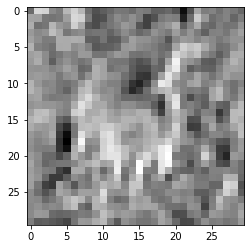

In [40]:
## The dimension are reduced bcz of kernel. 
plt.imshow(out[0, 0].detach(), cmap='gray')
plt.show()

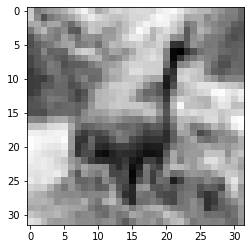

In [41]:
plt.imshow(img[0,0].detach(), cmap='gray')
plt.show()

In [42]:
conv_pad = nn.Conv2d(3, 16, kernel_size=3, padding=1)

In [43]:
img, label = cifar_2[0]
img = img.unsqueeze(0)
out = conv_pad(img)
out.shape

torch.Size([1, 16, 32, 32])

In [44]:
pool = nn.MaxPool2d(2)
output = pool(img)
img.shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

### Convolution Model

In [45]:
model = nn.Sequential(
nn.Conv2d(3, 16, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
nn.Conv2d(16, 8, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
# ...
nn.Linear(8 * 8 * 8, 32),
nn.Tanh(),
nn.Linear(32, 2))

In [46]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### Building Convolution Model using nn.Module

In [47]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.max1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.max2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.max1(self.act1(self.conv1(x)))
        out = self.max2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # in above model ... was missing this line !
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [48]:
model = net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

3C * 3 * 3 * 16 = 432 #16 Output Channel - From Conv1 Layer

16C = 16 # tanh

16C * 3 * 3 * 8 = 1152 #8 Output Channel - From Conv2 Layer

8C = 8 # tanh

8C * 8H * 8W * 32 = 16384 #32 Output Channel from Linear Layer 1

32C = 32 # tanh

32C * 2 = 64 #2 Output Layer from Linear Layer 2

2 Class Probabilities 

In [49]:
model

net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): Tanh()
  (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [50]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.Conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.Conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.Conv2(out)),2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [51]:
model = Net()
model(img)

tensor([[0.1333, 0.2398]], grad_fn=<AddmmBackward>)

In [52]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        """
        Loops over our dataset in the batches the data loader creates for us
        """
        for imgs, labels in train_loader:
            #Feeds a batch through our model ...
            outputs = model(imgs)
            
            # ... and computes the loss we wish to minimize
            loss = loss_fn(outputs, labels)
            
            #After getting rid of the gradients from the last round ...
            optimizer.zero_grad()
            
            #... performs the backward step. That is, we compute the gradients of all parameters we want the network to learn.
            loss.backward()
            
            # Updates the model
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:

            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

In [53]:
train_loader = torch.utils.data.DataLoader(cifar_2, batch_size=64,
shuffle=True)

In [54]:
model = Net()

In [55]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [56]:
%%time
training_loop(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
)

2020-07-17 16:37:20.686576 Epoch 1, Training loss 0.6239917893318614
2020-07-17 16:37:31.812774 Epoch 10, Training loss 0.35999924969521296
2020-07-17 16:37:44.041104 Epoch 20, Training loss 0.31443331718065176
2020-07-17 16:37:57.989455 Epoch 30, Training loss 0.2892987493686615
2020-07-17 16:38:11.323510 Epoch 40, Training loss 0.2684701074175774
2020-07-17 16:38:24.219665 Epoch 50, Training loss 0.25094598731037915
2020-07-17 16:38:36.345529 Epoch 60, Training loss 0.23674602550306137
2020-07-17 16:38:49.225030 Epoch 70, Training loss 0.22076270715066582
2020-07-17 16:39:02.234376 Epoch 80, Training loss 0.20623055717368036
2020-07-17 16:39:15.187303 Epoch 90, Training loss 0.1959344895592161
2020-07-17 16:39:28.161248 Epoch 100, Training loss 0.18336010524991211
CPU times: user 29min 32s, sys: 42.6 s, total: 30min 14s
Wall time: 2min 8s


In [57]:
train_loader = torch.utils.data.DataLoader(cifar_2, batch_size=64,
shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
shuffle=False)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print("Accuracy {}: {:.2f}".format(name , correct / total))
        
validate(model, train_loader, val_loader)

Accuracy train: 0.90
Accuracy val: 0.86


In [60]:
torch.save(model.state_dict(), "model/" + 'birds_vs_airplanes.pt')

In [61]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load("model/" + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [81]:
# img, label = cifar2_val[0]

# loaded_model.eval()
# with torch.no_grad():
    
#     output = loaded_model(img.unsqueeze(0))
#     _, predicted = torch.max(output, dim=1)
#     print(predicted.item())
#     print(class_names[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


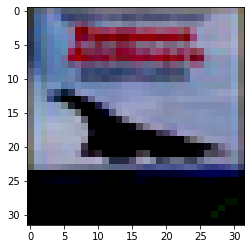

In [80]:
plt.imshow(img.permute(1,2,0))
plt.savefig('/home/mayur/Desktop/Model_Deployment/plane.jpg')

### Training on Cuda

In [86]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [87]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        """
        Loops over our dataset in the batches the data loader creates for us
        """
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            #Feeds a batch through our model ...
            outputs = model(imgs)
            
            # ... and computes the loss we wish to minimize
            loss = loss_fn(outputs, labels)
            
            #After getting rid of the gradients from the last round ...
            optimizer.zero_grad()
            
            #... performs the backward step. That is, we compute the gradients of all parameters we want the network to learn.
            loss.backward()
            
            # Updates the model
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:

            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

In [88]:
train_loader = torch.utils.data.DataLoader(cifar_2, batch_size=64,shuffle=True)

In [89]:
%%time

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
)

2020-07-12 20:22:51.042898 Epoch 1, Training loss 0.605764420358998
2020-07-12 20:22:53.365773 Epoch 10, Training loss 0.37257426768351515
2020-07-12 20:22:55.966001 Epoch 20, Training loss 0.3153013024170687
2020-07-12 20:22:58.715658 Epoch 30, Training loss 0.28940475907675023
2020-07-12 20:23:01.296965 Epoch 40, Training loss 0.2707495789049537
2020-07-12 20:23:03.887686 Epoch 50, Training loss 0.24903670987885468
2020-07-12 20:23:06.472710 Epoch 60, Training loss 0.23125037270936238
2020-07-12 20:23:09.055006 Epoch 70, Training loss 0.21709420465549845
2020-07-12 20:23:11.648606 Epoch 80, Training loss 0.20504711554118782
2020-07-12 20:23:14.227783 Epoch 90, Training loss 0.18978152884419558
2020-07-12 20:23:16.784610 Epoch 100, Training loss 0.1784428007853259
CPU times: user 25.9 s, sys: 266 ms, total: 26.2 s
Wall time: 26.1 s


## Ways to Reduce Overfitting

### Regularization

In [90]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # Replaces pow(2.0) with abs() for L1 regularization
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

### Dropout

In [92]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### Checking Distribution of Weights of trained model

In [98]:
param = [p.view(-1) for p in model.parameters()]

In [121]:
wgt = param[7].cpu().data.numpy()

(array([ 5., 13., 44., 80., 75., 81., 73., 51.,  7.,  3.]),
 array([-0.46112216, -0.369093  , -0.27706388, -0.18503472, -0.09300558,
        -0.00097643,  0.09105272,  0.18308187,  0.27511102,  0.36714014,
         0.4591693 ], dtype=float32),
 <a list of 10 Patch objects>)

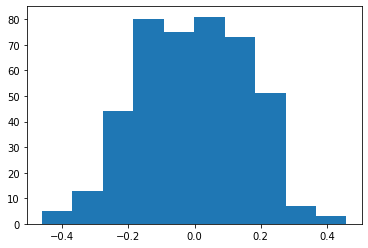

In [107]:
plt.hist(wgt)

(array([1., 1., 2., 2., 0., 3., 1., 1., 3., 2.]),
 array([-0.34008625, -0.29337847, -0.24667071, -0.19996293, -0.15325515,
        -0.10654738, -0.0598396 , -0.01313183,  0.03357594,  0.08028372,
         0.1269915 ], dtype=float32),
 <a list of 10 Patch objects>)

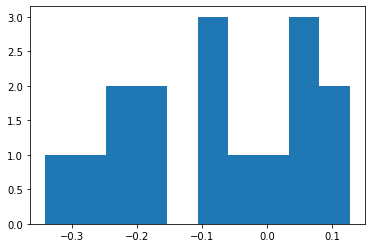

In [109]:
plt.hist(wgt)

(array([ 15.,  56., 150., 238., 303., 229., 115.,  36.,   4.,   6.]),
 array([-0.2555791 , -0.19547646, -0.1353738 , -0.07527114, -0.01516848,
         0.04493418,  0.10503684,  0.1651395 ,  0.22524217,  0.2853448 ,
         0.34544748], dtype=float32),
 <a list of 10 Patch objects>)

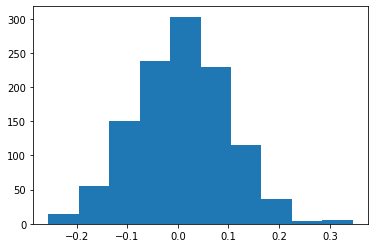

In [111]:
plt.hist(wgt)

(array([1., 2., 1., 0., 0., 1., 0., 1., 1., 1.]),
 array([-0.2366386 , -0.20400186, -0.17136511, -0.13872837, -0.10609162,
        -0.07345487, -0.04081813, -0.00818138,  0.02445536,  0.05709211,
         0.08972885], dtype=float32),
 <a list of 10 Patch objects>)

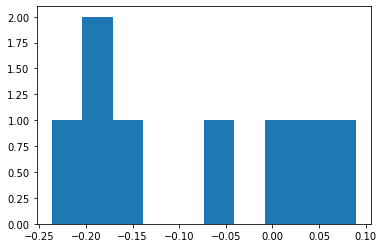

In [113]:
plt.hist(wgt)

(array([  23.,  102.,  718., 3423., 4971., 4727., 2046.,  321.,   44.,
           9.]),
 array([-0.14312217, -0.11343018, -0.08373819, -0.05404621, -0.02435423,
         0.00533776,  0.03502975,  0.06472173,  0.09441371,  0.1241057 ,
         0.15379769], dtype=float32),
 <a list of 10 Patch objects>)

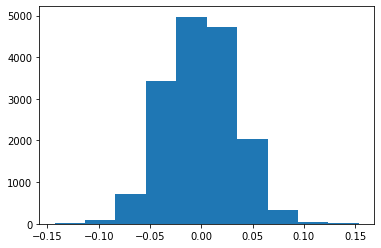

In [115]:
plt.hist(wgt)

(array([1., 1., 5., 4., 6., 5., 4., 3., 0., 3.]),
 array([-0.12240616, -0.10064252, -0.07887886, -0.05711522, -0.03535157,
        -0.01358792,  0.00817573,  0.02993938,  0.05170303,  0.07346667,
         0.09523033], dtype=float32),
 <a list of 10 Patch objects>)

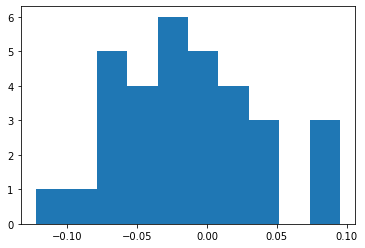

In [117]:
plt.hist(wgt)

(array([ 1.,  5.,  8., 12.,  3., 12.,  8., 11.,  3.,  1.]),
 array([-0.759473  , -0.60569566, -0.45191833, -0.29814097, -0.14436363,
         0.00941372,  0.16319107,  0.3169684 ,  0.47074577,  0.6245231 ,
         0.77830046], dtype=float32),
 <a list of 10 Patch objects>)

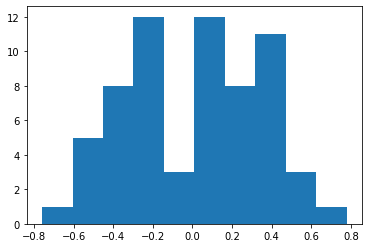

In [119]:
plt.hist(wgt)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-1.0878402e-01, -8.7036297e-02, -6.5288581e-02, -4.3540858e-02,
        -2.1793138e-02, -4.5418739e-05,  2.1702301e-02,  4.3450020e-02,
         6.5197743e-02,  8.6945459e-02,  1.0869318e-01], dtype=float32),
 <a list of 10 Patch objects>)

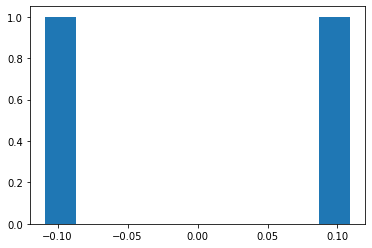

In [122]:
plt.hist(wgt)

### Batch Normalization - 

Batch normalization is to rescale the inputs to the activa-
tions of the network so that minibatches have a certain desirable distribution. Recall-
ing the mechanics of learning and the role of nonlinear activation functions, this
helps avoid the inputs to activation functions being too far into the saturated portion
of the function, thereby killing gradients and slowing training.
In practical terms, batch normalization shifts and scales an intermediate input
using the mean and standard deviation collected at that intermediate location over
the samples of the minibatch. The regularization effect is a result of the fact that an
individual sample and its downstream activations are always seen by the model as
shifted and scaled, depending on the statistics across the randomly extracted mini-
batch. This is in itself a form of principled augmentation.

Since the aim for batch normalization is to rescale the inputs of the activa-
tions, the natural location is after the linear transformation (convolution, in this case)

In [124]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### Depth of Neural Networks

**As the depth of the network increase the gradients tends to move to zero, causing Vanishing Gradient Problem, which is over come by Skip Conections**

**A skip connection is nothing but the addition of the input to the output of a block of layers. This is exactly how it is done in PyTorch**

In [125]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
        kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

**The Idea of adding skip connection was originated from residual networks (Resnet). Adding a skip connection a la ResNet to this model amounts to adding the output of the first layer in the forward function to the input of the third layer**

In [127]:
class NetRes(nn.Module):
    
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
        kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
    
        return out

*What's happening above ?*

**In other words, we’re using the output of the first activations as inputs to the last, in
addition to the standard feed-forward path. This is also referred to as identity mapping.**

*So, how does this alleviate the issues with vanishing gradients we were mentioning
earlier?*

**Thinking about backpropagation, we can appreciate that a skip connection, or a
sequence of skip connections in a deep network, creates a direct path from the deeper
parameters to the loss. This makes their contribution to the gradient of the loss more
direct, as partial derivatives of the loss with respect to those parameters have a chance
not to be multiplied by a long chain of other operations.
It has been observed that skip connections have a beneficial effect on convergence
especially in the initial phases of training. Also, the loss landscape of deep residual
networks is a lot smoother than feed-forward networks of the same depth and width.**

### Building 100 Layer Network 

In [129]:
class ResBlock(nn.Module):

    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
        padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
        nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        
        return out + x

The BatchNorm layer would cancel the effect of bias, so it is customarily left out, as in bias=False.

Uses custom initializations
. kaiming_normal_ initializes with
normal random elements with standard
deviation as computed in the ResNet paper.
The batch norm is initialized to produce output
distributions that initially have 0 mean and 0.5 variance.

In [130]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
        *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [161]:
### Keeping Images intact with padding 

In [160]:
conv_pad = nn.Conv2d(3, 32, kernel_size=5, padding=2)
img, label = cifar_2[0]
img = img.unsqueeze(0)
out = conv_pad(img)
out.shape

torch.Size([1, 32, 28, 28])

In [189]:
### Exercises -> width - kernel_size + 1
class NN_Model(nn.Module):
    def __init__(self, n_channel):
        super().__init__()
        self.n_channel = n_channel
        self.conv1 = nn.Conv2d(3, n_channel, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=n_channel)
        self.conv2 = nn.Conv2d(n_channel, n_channel//2, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=n_channel//2)
        self.fc1 = nn.Linear(8 * 8 * n_channel//2 , 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.bn2(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_channel // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [190]:
fresh_model = NN_Model(n_channel=16)

In [191]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for img, label in train_loader:
            img = img.to('cuda')
            label = label.to('cuda')
            output = model(img)
            
            loss = loss_fn(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Loss: {loss}')

In [192]:
fresh_model.to('cuda')

NN_Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [193]:
optimizer = optim.SGD(fresh_model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

training_loop(n_epochs = 100,optimizer = optimizer,model = fresh_model,loss_fn = loss,train_loader = train_loader)

Epoch: 10, Loss: 0.6395094990730286
Epoch: 20, Loss: 0.6124091148376465
Epoch: 30, Loss: 0.6007277965545654
Epoch: 40, Loss: 0.5745313763618469
Epoch: 50, Loss: 0.5408896207809448
Epoch: 60, Loss: 0.5111746788024902
Epoch: 70, Loss: 0.48889583349227905
Epoch: 80, Loss: 0.4641161262989044
Epoch: 90, Loss: 0.43953585624694824
Epoch: 100, Loss: 0.41507869958877563


In [194]:
train_loader = torch.utils.data.DataLoader(cifar_2, batch_size=64,
shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
shuffle=False)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to('cuda')
                labels = labels.to('cuda')
                outputs = fresh_model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print("Accuracy {}: {:.2f}".format(name , correct / total))
        
validate(model, train_loader, val_loader)

Accuracy train: 0.89
Accuracy val: 0.88


### Changing Kernel from 5,5 to 1,3 - Lookout for padding

In [20]:
conv_pad = nn.Conv2d(3, 32, kernel_size=(1,3), padding=(0,1))
img, label = cifar_2[0]
img = img.unsqueeze(0)
out = conv_pad(img)
out.shape

torch.Size([1, 32, 32, 32])

In [45]:
### Exercises -> width - kernel_size + 1
class NN_Model_K(nn.Module):
    def __init__(self, n_channel):
        super().__init__()
        self.n_channel = n_channel
        self.conv1 = nn.Conv2d(3, n_channel, kernel_size=(1,3), padding=(0,1))
        self.bn1 = nn.BatchNorm2d(num_features=n_channel)
        self.conv2 = nn.Conv2d(n_channel, n_channel//2, kernel_size=(1,3), padding=(0,1))
        self.bn2 = nn.BatchNorm2d(num_features=n_channel//2)
        self.fc1 = nn.Linear(8 * 8 * n_channel//2 , 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.max_pool2d(torch.relu(out), 2)
        out = self.bn2(self.conv2(out))
        out = F.max_pool2d(torch.relu(out), 2)
        out = out.view(-1, 8 * 8 * self.n_channel // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [46]:
fresh_model_k = NN_Model_K(n_channel=32)

In [47]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for img, label in train_loader:
            img = img.to('cuda')
            label = label.to('cuda')
            output = model(img)
            
            loss = loss_fn(output, label)
            
            loss_train += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch == 1 or epoch % 10 == 0:

            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

In [48]:
fresh_model_k.to('cuda')

NN_Model_K(
  (conv1): Conv2d(3, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [50]:
optimizer = optim.SGD(fresh_model_k.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar_2, batch_size=64,shuffle=False)
training_loop(n_epochs = 100,optimizer = optimizer,model = fresh_model_k,loss_fn = loss,train_loader = train_loader)

2020-07-20 10:34:04.579627 Epoch 1, Training loss 0.6357857163544673
2020-07-20 10:34:07.567076 Epoch 10, Training loss 0.3856166413255558
2020-07-20 10:34:10.708750 Epoch 20, Training loss 0.3382227804250778
2020-07-20 10:34:13.773509 Epoch 30, Training loss 0.3110316048382194
2020-07-20 10:34:16.855919 Epoch 40, Training loss 0.2933084041259851
2020-07-20 10:34:19.871960 Epoch 50, Training loss 0.28022247780660153
2020-07-20 10:34:23.029456 Epoch 60, Training loss 0.26937293104685034
2020-07-20 10:34:26.018041 Epoch 70, Training loss 0.25972320096697776
2020-07-20 10:34:29.084593 Epoch 80, Training loss 0.2507866209574566
2020-07-20 10:34:32.138758 Epoch 90, Training loss 0.24222446081175167
2020-07-20 10:34:35.166683 Epoch 100, Training loss 0.23400165069444923


In [51]:

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
shuffle=False)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to('cuda')
                labels = labels.to('cuda')
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print("Accuracy {}: {:.2f}".format(name , correct / total))
        
validate(fresh_model_k, train_loader, val_loader)

Accuracy train: 0.90
Accuracy val: 0.88


In [63]:
torch.save(fresh_model_k.state_dict(), "/home/mayur/Desktop/Model_Deployment/model/" + 'birds_vs_airplanes.pt')